The purpose of this notebook it to provide scientific proof that cats are stranger than dogs (possibly of alien origin). Cats' features are of enormous variety compared to dogs and simply annoying to our brains. 

Let's start by following the procedure to rearrange folders:
https://github.com/daavoo/kaggle_solutions/blob/master/dogs_vs_cats/01_rearrange_folders.ipynb

In [301]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import zipfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

from skimage import color, io
from scipy.misc import imresize

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, Activation, GlobalAveragePooling2D
from keras.layers import merge, Input, Lambda
from keras.callbacks import EarlyStopping
from keras.models import Model

np.random.seed(31337)

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

Load original Keras ResNet50 model without the top layer.

In [188]:

from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

resnet_codes_model = ResNet50(input_shape=(300,300,3), include_top=False, weights='imagenet')    
#resnet_codes_model.summary()

Add a Pooling layer at the top to extract the CNN coded (aka bottleneck)

In [4]:
# Final model
model=Model(input=resnet_codes_model.input, output=GlobalAveragePooling2D()(resnet_codes_model.output))

In [ ]:
model.summary()

The following preprocessing is not proper for the ResNet as it uses mean image rather than mean pixel (I chose VGG paper values) yet it yields little numerical differencies hence works properly and is more than enough for this experiment.

Note that it's required to install github version of keras for preprocessing_function to work with: 
```
pip install git+https://github.com/fchollet/keras.git --upgrade
```


In [6]:
from keras.preprocessing.image import ImageDataGenerator
def img_to_bgr(im):
    # the following BGR values should be subtracted: [103.939, 116.779, 123.68]. (VGG)
    return (im[:,:,::-1] - np.array([103.939, 116.779, 123.68]))

datagen = ImageDataGenerator(rescale=1., preprocessing_function=img_to_bgr) #(rescale=1./255)

Get the trainign and validation DirectoryIterators

In [233]:
train_batches = datagen.flow_from_directory("train", model.input_shape[1:3], shuffle=False, batch_size=32)
valid_batches = datagen.flow_from_directory("valid", model.input_shape[1:3], shuffle=False, batch_size=32)
#test_batches = datagen.flow_from_directory("test", model.input_shape[1:3], shuffle=False, batch_size=32, class_mode=None)


Found 22949 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Obtain the CNN codes for all images (it takes ~10 minutes on GTX 1080 GPU)

In [8]:
train_codes = model.predict_generator(train_batches, train_batches.nb_sample)

In [9]:
valid_codes = model.predict_generator(valid_batches, valid_batches.nb_sample)

In [10]:
#test_codes = model.predict_generator(test_batches, test_batches.nb_sample)

Save the CNN codes for futher analysys

In [11]:
import h5py

from keras.utils.np_utils import to_categorical

with h5py.File("ResNet50-300x300_codes-train.h5") as hf:
    hf.create_dataset("X_train", data=train_codes)
    hf.create_dataset("X_valid", data=valid_codes)
    hf.create_dataset("Y_train", data=to_categorical(train_batches.classes))
    hf.create_dataset("Y_valid", data=to_categorical(valid_batches.classes))

with h5py.File("ResNet50-300x300_codes-test.h5") as hf:
    hf.create_dataset("X_test", data=test_codes)


Compute mean values of codes across all training codes

In [264]:
def get_codes_by_class(X,Y):
    l=len(Y)
    if (len(X)!=l):
        raise Exception("X and Y are of different lengths")
    classes=set(Y)
    
    return [[X[i] for i in xrange(l) if Y[i]==c] for c in classes], classes
    
class_codes, classes=get_codes_by_class(train_codes, train_batches.classes)

cats=np.mean(class_codes[0],0)
dogs=np.mean(class_codes[1],0)
cats=cats/cats.max()
dogs=dogs/dogs.max()

Visualize codes as images. As it can be clearly seen, Cats have many different features (plenty of high value - dark spots) while dogs highly activate only two neurons (two distinct dark spots). 

It can be concluded that cats activate more brain regions or are more annoying than dogs.

It's even more apparent when looking at the histograms of frequency domain.

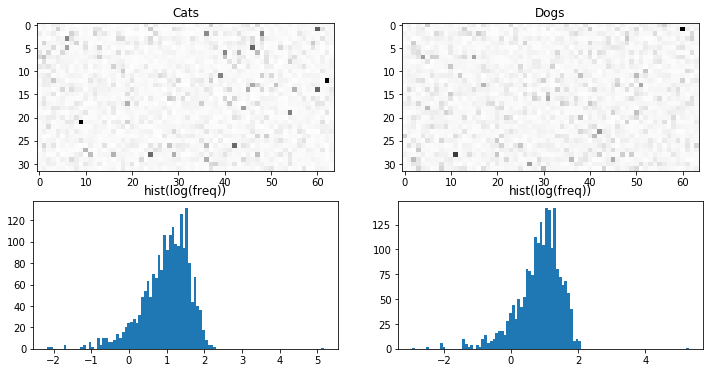

In [324]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
ax[0,0].imshow(cats.reshape(32,64),cmap="Greys")
ax[0,0].set_title('Cats')

ax[0,1].imshow(dogs.reshape(32,64),cmap="Greys")
ax[0,1].set_title('Dogs')

freq = np.fft.fft2(cats.reshape(32,64))
freq = np.abs(freq)
ax[1,0].hist(np.log(freq).ravel(), bins=100)
ax[1,0].set_title('hist(log(freq))')

freq = np.fft.fft2(dogs.reshape(32,64))
freq = np.abs(freq)
ax[1,1].hist(np.log(freq).ravel(), bins=100)
ax[1,1].set_title('hist(log(freq))')

plt.show()